In [1]:
import pandas as pd
from music21 import converter
from tqdm import tqdm

# --- Load the parsed data ---
df = pd.read_csv("../data/processed/parsed_tunes.csv")
print(f"Loaded {len(df)} tunes")

df.head()

Loaded 51128 tunes


,tune_id,name,type,meter,mode,abc,date,username
0,18105,"$150 Boot, The",polka,2/4,Gmajor,|:d>g fe|dB AG|E/F/G E/F/G|BA GF|\r\nd>g fe|dB...,2019-07-06 04:39:09,NfldWhistler
1,11931,'G Iomain Nan Gamhna,slip jig,9/8,Gmajor,dBB B2 A BAG|dBB Bcd efg|dBB B2 A BAG|eAA dBG ...,2012-05-17 07:49:26,iliketurtles
2,11931,'G Iomain Nan Gamhna,slip jig,9/8,Amixolydian,|:dBB BBA BAG|dBB Bcd efg|dBB BBA BAG|e2A dBG ...,2023-11-25 22:54:00,birlibirdie
3,15326,'S Ann An Ìle,strathspey,4/4,Gmajor,|:G>A B>G c>A B>G|E<E A>G F<D D2|G>A B>G c>A B...,2016-03-31 15:34:45,danninagh
4,15326,'S Ann An Ìle,strathspey,4/4,Gmajor,"uD2|:{F}v[G,2G2]uB>ud c>A B>G|{D}E2 uA>uG F<D ...",2016-04-03 09:15:08,DonaldK


In [2]:
# --- Helper to build correct ABC K: field ---
def build_key_field(mode_str):
    if not isinstance(mode_str, str):
        return "C"

    if len(mode_str) < 2:
        return "C"

    if mode_str[1].islower():
        tonic = mode_str[:2].capitalize()
        mode = mode_str[2:].lower()
    else:
        tonic = mode_str[0].upper()
        mode = mode_str[1:].lower()

    mode_map = {
        "major": "",
        "minor": "m",
        "dorian": "dor",
        "mixolydian": "mix",
        "lydian": "lyd",
        "phrygian": "phr",
        "aeolian": "aeo",
        "locrian": "loc"
    }

    suffix = mode_map.get(mode, "")
    return f"{tonic}{suffix}"

# --- ABC parsing and structure analysis ---
def analyze_abc(abc_string, title="Tune", meter="4/4", mode="Dmajor"):
    try:
        k_field = build_key_field(mode)
        abc_full = f"""X:1\nT:{title}\nM:{meter}\nK:{k_field}\n{abc_string}"""
        score = converter.parse(abc_full, format='abc')
        num_measures = len(score.parts[0].getElementsByClass('Measure'))
        num_notes = len(score.flat.notes)
        return pd.Series({
            'num_measures': num_measures,
            'num_notes': num_notes
        })
    except Exception:
        return pd.Series({'num_measures': None, 'num_notes': None})

In [3]:
# --- Apply to sample ---
sample_df = df.sample(100, random_state=42).copy()
tqdm.pandas(desc="Analyzing ABC")

analysis_results = sample_df.progress_apply(
    lambda row: analyze_abc(row['abc'], title=row['name'], meter=row['meter'], mode=row['mode']),
    axis=1
)

# --- Merge and export ---
sample_df = pd.concat([sample_df, analysis_results], axis=1)
sample_df.head()

Analyzing ABC:   0%|                                                                               | 0/100 [00:00<?, ?it/s]/Users/wcramer2/miniconda3/envs/musicproj/lib/python3.13/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
Analyzing ABC: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.37it/s]


,tune_id,name,type,meter,mode,abc,date,username,num_measures,num_notes
5211,6836,Boney's Retreat,hornpipe,4/4,Dmajor,|:D3 E F3 G|A2 d2 AGF2|GFE2 FED2|e2 d2 cA3|\r\...,2007-02-19 07:57:26,Ptarmigan,16.0,67.0
33401,1126,"Munster Cloak, The",waltz,3/4,Dmajor,|:D2 DE FD|E2 EF GA|D2 DE FA|G2 E2 A2|\r\nD2 D...,2024-08-08 23:19:19,JACKB,17.0,70.0
14960,791,Father Kelly's,reel,4/4,Gmajor,|:GA|B2 GB AGEG|DGGF GABG|c2 AB cBAG|EAAG FDGA...,2014-04-20 16:03:28,Lucy Rietmann,18.0,118.0
9634,11682,Coolderry Bridge,reel,4/4,Dmajor,"FE|:DA,A,2 DEFB|BAFA dcdf|feef eBBA|G2FG EGFE|...",2013-10-08 02:10:49,Dr. Tøm,26.0,196.0
8465,15055,Cider Street,reel,4/4,Gmixolydian,|:G2 dc BGDG|EDCE FAcA|GABd cABG|FGDE F2 dc|\r...,2023-06-21 08:41:49,Nigel Gatherer,24.0,171.0


In [4]:
sample_df.to_csv("../data/processed/sample_analysis.csv", index=False)
print("[\u2713] Sample analysis saved to data/processed/sample_analysis.csv")

[✓] Sample analysis saved to data/processed/sample_analysis.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/parsed_tunes.csv")
print(df["mode"].value_counts().sort_values(ascending=True))

mode
Bmixolydian       34
Emixolydian       88
Fdorian          117
Cdorian          143
Bdorian          157
Gmixolydian      202
Emajor           315
Gdorian          431
Ddorian          594
Dminor           727
Gminor           736
Fmajor           859
Cmajor          1222
Dmixolydian     1496
Aminor          1628
Amixolydian     1694
Bminor          2011
Edorian         2419
Eminor          2870
Adorian         3059
Amajor          3622
Dmajor         13216
Gmajor         13488
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51128 entries, 0 to 51127
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tune_id   51128 non-null  int64 
 1   name      51128 non-null  object
 2   type      51128 non-null  object
 3   meter     51128 non-null  object
 4   mode      51128 non-null  object
 5   abc       51128 non-null  object
 6   date      51128 non-null  object
 7   username  51128 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 20592 entries, 0 to 51124
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tune_id   20592 non-null  int64 
 1   name      20592 non-null  object
 2   type      20592 non-null  object
 3   meter     20592 non-null  object
 4   mode      20592 non-null  object
 5   abc       20592 non-null  object
 6   date      20592 non-null  object
 7   username  20

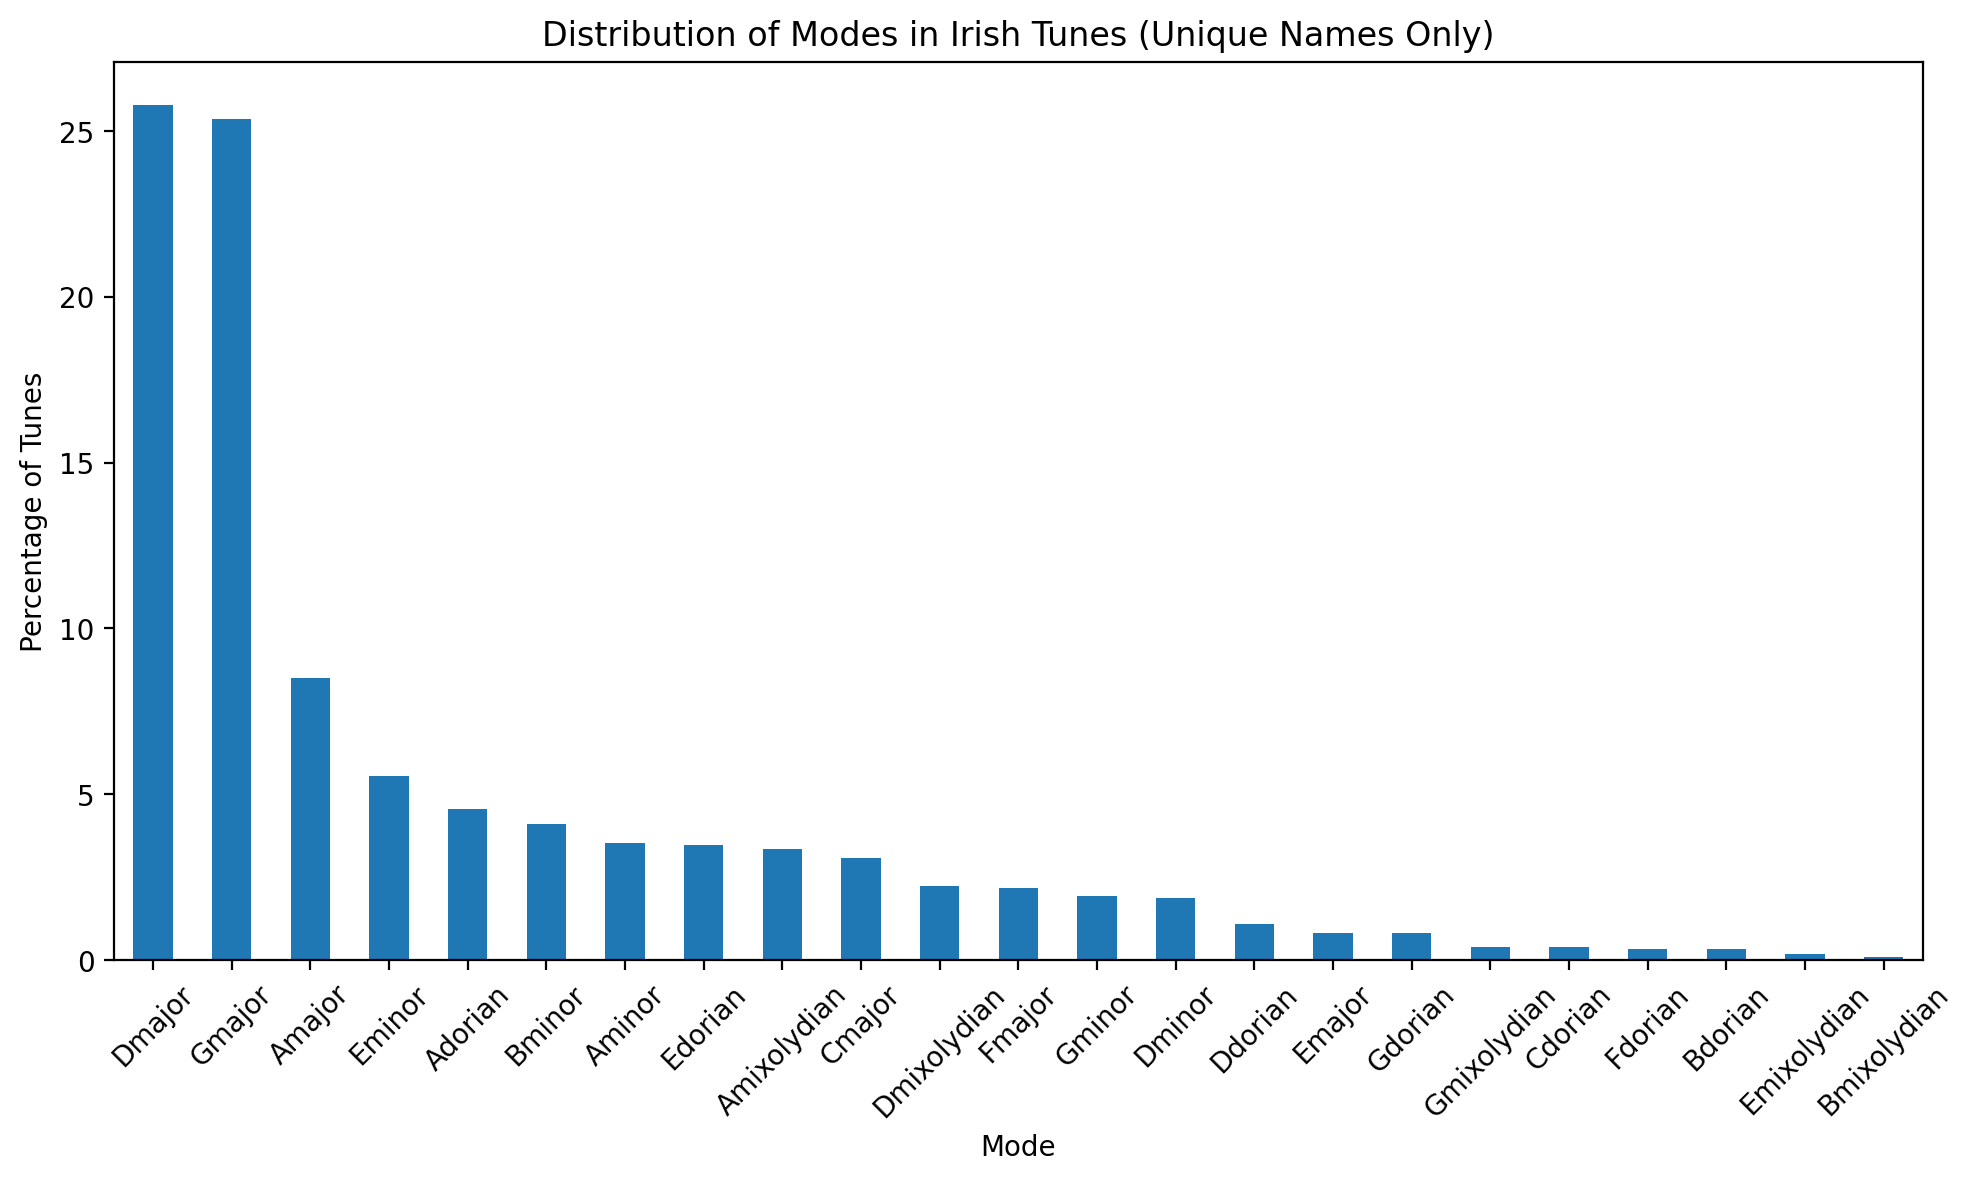

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your parsed tunes file
df = pd.read_csv("../data/processed/parsed_tunes.csv")

df.info()

# Keep only tunes with unique names
df_unique = df.drop_duplicates(subset="name")

df_unique.info()

# Compute value counts as percentages
mode_counts = df_unique["mode"].value_counts(normalize=True) * 100

# Plot as bar chart
mode_counts.plot(kind="bar", figsize=(10, 6))
plt.title("Distribution of Modes in Irish Tunes (Unique Names Only)")
plt.xlabel("Mode")
plt.ylabel("Percentage of Tunes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
known_modes = [
    "major", "minor", "dorian", "mixolydian", "lydian", 
    "phrygian", "aeolian", "locrian"
]

def extract_mode_type(mode_str):
    if not isinstance(mode_str, str):
        return None
    mode_str = mode_str.lower().strip()
    for mode in known_modes:
        if mode_str.endswith(mode):
            return mode
    return "other"


/var/folders/mw/4rh5zx7d3233v9j7gy786qpm0000gr/T/ipykernel_15847/520753813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["mode_type"] = df_unique["mode"].apply(extract_mode_type)


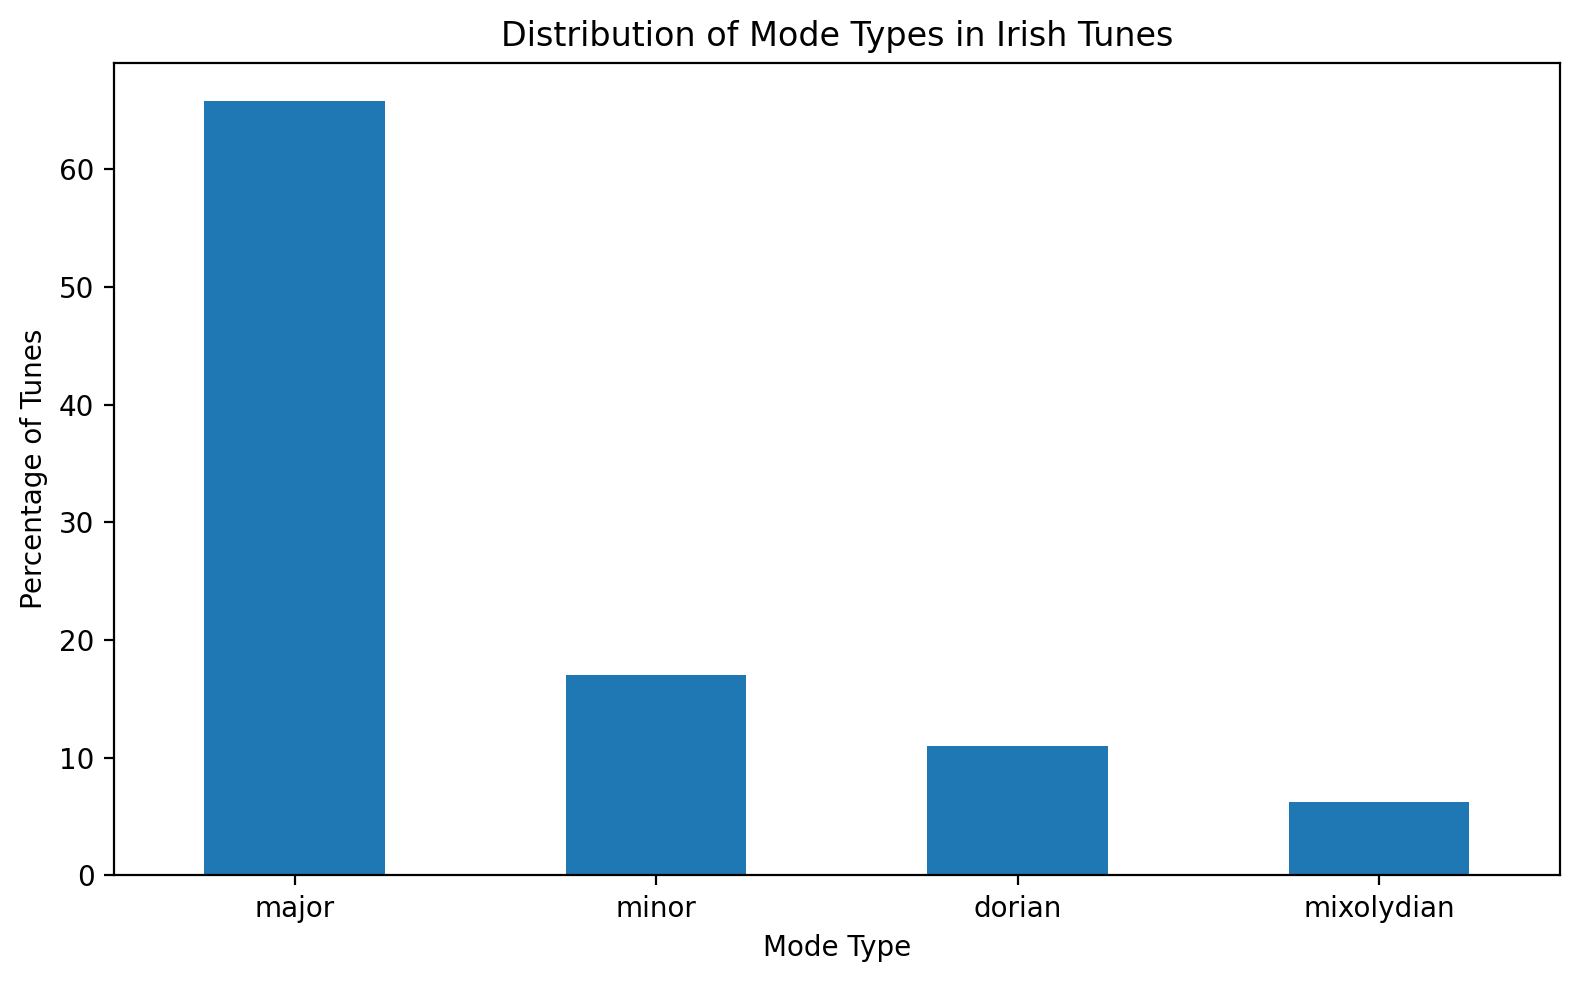

In [8]:
# Apply the function
df_unique["mode_type"] = df_unique["mode"].apply(extract_mode_type)

# Compute percentages
mode_pct = df_unique["mode_type"].value_counts(normalize=True) * 100

# Plot
mode_pct.plot(kind="bar", figsize=(8, 5))
plt.title("Distribution of Mode Types in Irish Tunes")
plt.xlabel("Mode Type")
plt.ylabel("Percentage of Tunes")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/mw/4rh5zx7d3233v9j7gy786qpm0000gr/T/ipykernel_15847/1566543413.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["mode_type"] = df_unique["mode"].apply(extract_mode_type)


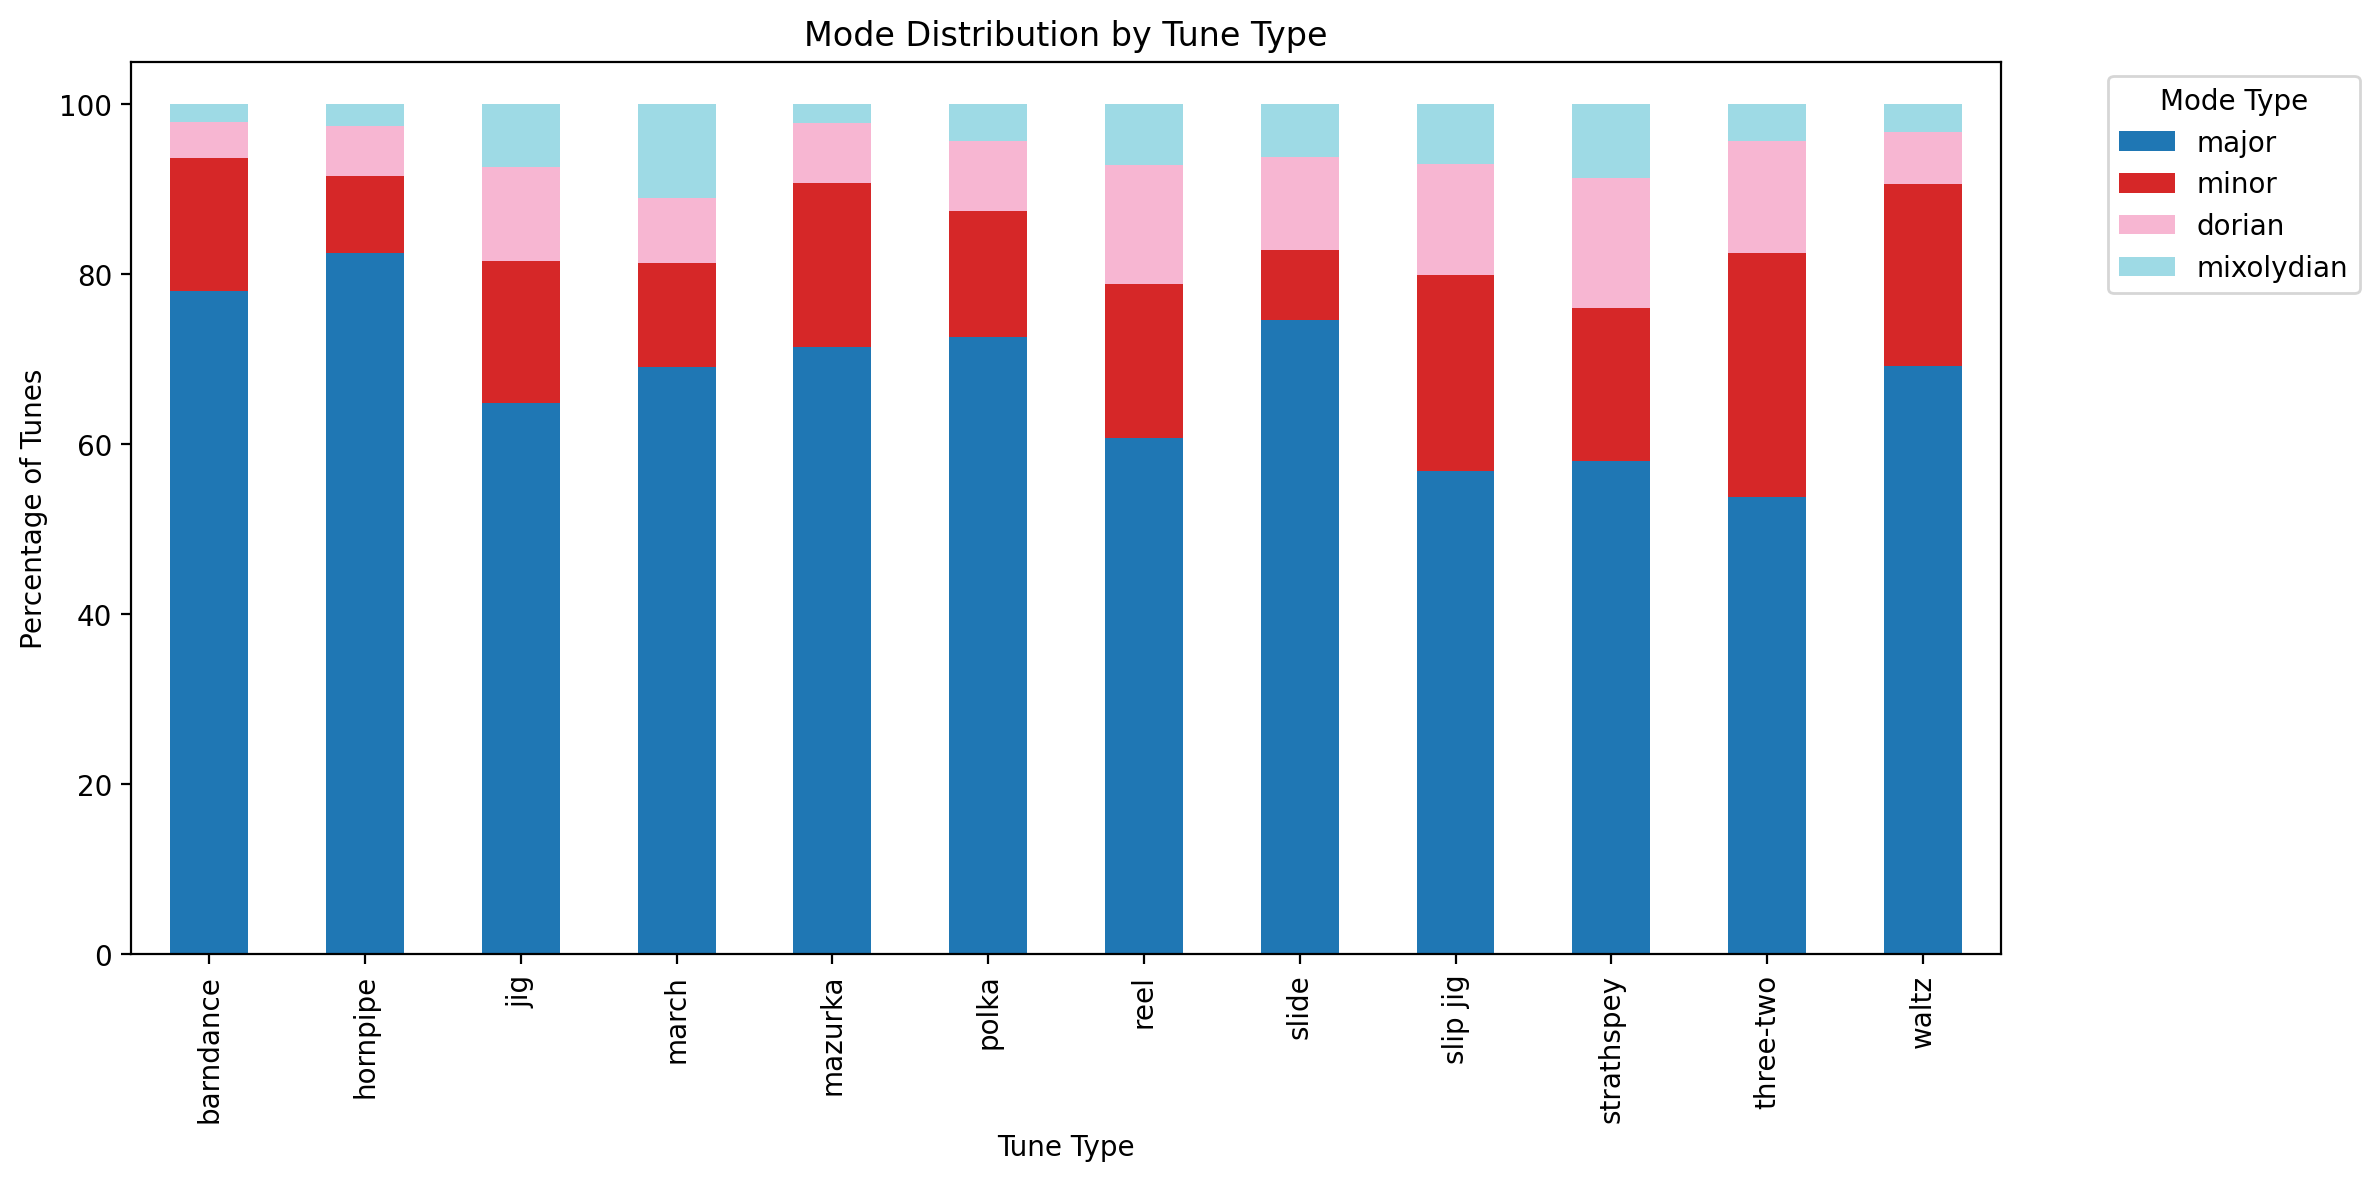

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

desired_mode_order = ["major", "minor", "dorian", "mixolydian"]

# Load and clean data
df = pd.read_csv("../data/processed/parsed_tunes.csv")

# Keep only tunes with unique names
df_unique = df.drop_duplicates(subset="name")

known_modes = [
    "major", "minor", "dorian", "mixolydian", "lydian", 
    "phrygian", "aeolian", "locrian"
]

def extract_mode_type(mode_str):
    if not isinstance(mode_str, str):
        return None
    mode_str = mode_str.lower().strip()
    for mode in known_modes:
        if mode_str.endswith(mode):
            return mode
    return "other"

df_unique["mode_type"] = df_unique["mode"].apply(extract_mode_type)

# Group and normalize
mode_by_type = (
    df_unique.groupby("type")["mode_type"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

# Reorder columns so major, minor, dorian, mixolydian are first
# and preserve any remaining modes
remaining = [col for col in mode_by_type.columns if col not in desired_mode_order]
ordered_columns = desired_mode_order + remaining
mode_by_type = mode_by_type[ordered_columns]

# Plot
mode_by_type.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Mode Distribution by Tune Type")
plt.xlabel("Tune Type")
plt.ylabel("Percentage of Tunes")
plt.legend(title="Mode Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
df["mode_type"].value_counts(dropna=False)

mode_type
major         32722
minor          7972
dorian         6920
mixolydian     3514
Name: count, dtype: int64